<a href="https://colab.research.google.com/github/Juanba98/Carlini-Wagner_L2/blob/main/Carlini%26Wagner_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision  --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


# Imports

In [2]:
"""
Carlini-Wagner attack (http://arxiv.org/abs/1608.04644).
Referential implementation:
- https://github.com/carlini/nn_robust_attacks.git
- https://github.com/kkew3/pytorch-cw2/blob/master/cw.py
"""

import operator as op

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim



from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import torch.nn.functional as F

#PATHS
from importlib.machinery import SourceFileLoader
from os.path import join
paths = SourceFileLoader('paths', '/content/paths.py').load_module()


#Utils

In [3]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
def show(imgs, gray = False):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        if(gray):
            axs[0, i].imshow(np.asarray(img).reshape(28,28),cmap="gray")
        else:
          axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Device to use

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# L2 attack
To ensure the modifitacions yields to a valid image, we use the third method of box contraints at the paper and we define  $\delta$ as:

$$\delta_{i} = \frac{1}{2}(tanh(w_{i}) + 1) - x_{i} $$

and we optimize over the variable $w$





 



## Attack

Given x, and choosing a target class $t$  ($t \neq C^{*}(x)$, beeing $C^{*}(x)$) the correct label of x we search for a $w$ that solves



$$minimize \ ||\delta||^{2}_{2} + c \cdot f(x + \delta)$$ 



with $f$ defined as

$$f(x') = max(max\{Z(x')_i :  i \neq t\} - Z(x')_t, -\kappa)$$

To control the confidence with which missclasifation ocurrs we adjust κ but we wil set it to 0 for out attack

## L2 formula

$$||x||_{2} = \sqrt{\sum_{i=1}^{n} x^{2}_{i}} $$

## Hyperparameters

In [6]:
SEARCH_STEPS = 9         # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
K = 0                    # (kappa) how strong the adversarial example should be (confidence)
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

In [7]:


class L2Adversary(object):
  
 
  def __init__(self, targeted=True, k=K, c_range=(INITIAL_CONST, 1e10),
                  search_steps=SEARCH_STEPS, max_steps=1000, abort_early=ABORT_EARLY,
                  box=(-1., 1.), learning_rate = LEARNING_RATE):


  
    self.targeted = targeted # type: bool param: True for targeted attack
    self.k = float(k) #type: int param: confidence
    self.c_range = (float(c_range[0]), float(c_range[1])) # type: Tuple[float, float], param: range of the constat c
    self.binary_search_steps = search_steps #type: int param: number of steps to perform binary search to find optimal c
    self.max_steps = max_steps #type: int param: Maximum number of iterations
    self.abort_early = abort_early #type bool param: If true, we break when the gradient descent gets stuck
    self.box = tuple(map(float, box))  # type: Tuple[float, float], param: (max,min) pixel value
    self.learning_rate = learning_rate #type: float param: the learning rate for Adam optimizer used over the perturbation
    self.ae_tol = 1e-4  # tolerance of early abort
    
    #?
    self.repeat = (self.binary_search_steps >= 10)

    #Used for the affine transformation fo the change-of-variable
    self.box_mul = (self.box[1]-self.box[0])/2
    self.box_plus = (self.box[1]+self.box[0])/2

  def attack(self,model, inputs, targets, num_classes ):


    '''
    :param model: Model to attack :type: nn.Module  
    :param inputs: original images of dimension [B x C x H x W].
    :param targets: the original image labels, or the attack target, of
              dimension [B]. If ``self.targeted`` is ``True``, then ``targets``
              is treated as the attack targets, otherwise the labels.
              :type: ???????????????????????
    :param num_clases: number of clases of the model :type: int  
    :return: Adversarial examples of dimension [B X C x H x W]
    '''


    # sanity check
    assert isinstance(model, nn.Module)
    assert len(inputs.size()) == 4
    assert len(targets.size()) == 1


    # get a copy of targets in numpy before moving to GPU, used when doing
    # the binary search on `scale_const`
    targets_np = targets.clone().cpu().numpy().astype(int)  # type: np.ndarray

    # we move the tensor to the same device as the model 
    inputs = inputs.to(device)  # type: torch.FloatTensor
    targets = targets.to(device)  # type: torch.FloatTensor 


    batch_size = targets.size()[0]  # type: int
 
    # `lower_bounds_np`, `upper_bounds_np` and `scale_consts_np` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds_np < scale_consts_np <= upper_bounds_np
    lower_bounds_np = np.zeros(batch_size)
    upper_bounds_np = np.ones(batch_size) * self.c_range[1]
    scale_consts_np = np.ones(batch_size) * self.c_range[0]

   

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`: the least L2 norms
    # - `o_best_l2_ppred`: the perturbed predictions made by the adversarial
    #    perturbations with the least L2 norms
    # - `o_best_advx`: the underlying adversarial example of
    #   `o_best_l2_ppred`
    o_best_l2 = np.ones(batch_size) * np.inf #dimension [B]
    o_best_l2_ppred = -np.ones(batch_size) #dimension [B]
    o_best_advx = inputs.clone().cpu().numpy()  # type: np.ndarray dimension [B x C x H x W]
    
    # convert `inputs` to tanh-space
    #https://pytorch.org/docs/stable/generated/torch.atanh.html
    inputs_tanh = torch.atanh((inputs - self.box_plus) / self.box_mul)
    

    

    # the one-hot encoding of `targets`
    targets_oh = torch.zeros(targets.size() + (num_classes,) ,requires_grad = False)  # type: torch.FloatTensor


    #targets.unsqueeze(1) type:torch.FloatTensor but scatter need a LongTensor as a index 
    targets_oh.scatter_(1, targets.unsqueeze(1).type('torch.LongTensor'), 1.0)

    targets_oh = targets_oh.to(device)
    

   
    #the perturbation in tanh-space
    pert_tanh = nn.Parameter(torch.zeros_like(inputs))  # type: torch.FloatTensor

    
    optimizer = optim.Adam([pert_tanh], lr=self.learning_rate)
    

    for outer_step  in range(self.binary_search_steps):

      #?
      if self.repeat and outer_step == self.binary_search_steps - 1:
        scale_consts_np = upper_bounds_np

      
      #We convert the np.array to a tensor
      scale_consts = torch.tensor(np.copy(scale_consts_np)).float()  # type: torch.FloatTensor
      scale_consts = scale_consts.to(device)
      print('Using scale consts:', list(scale_consts_np))

     
      # the minimum L2 norms of perturbations found during optimization
      best_l2 = np.ones(batch_size) * np.inf

      # the perturbed predictions corresponding to `best_l2`, to be used
      # in binary search of `scale_const`
      best_l2_ppred = -np.ones(batch_size)

      # previous (summed) batch loss, to be used in early stopping policy
      prev_batch_loss = np.inf  # type: float

      for optim_step in range(self.max_steps):

        batch_loss, pert_norms_np, pert_outputs_np, advxs_np = \
            self._optimize(model, optimizer, inputs_tanh,
                            pert_tanh,  targets_oh,
                            scale_consts)
            
        if optim_step % 10 == 0: print(f'batch {optim_step} loss: {batch_loss}')  

        if self.abort_early and not optim_step % (self.max_steps // 10):

            #If loss increse enough we abort
            if batch_loss > prev_batch_loss * (1 - self.ae_tol):
                break
            prev_batch_loss = batch_loss

        # update best attack found during optimization
        pert_predictions_np = np.argmax(pert_outputs_np, axis=1)

      
        comp_pert_predictions_np = np.argmax(
                self._compensate_confidence(pert_outputs_np,
                                            targets_np),
                axis=1)
       
        #for each image
        for i in range(batch_size):

            l2 = pert_norms_np[i]
            cppred = comp_pert_predictions_np[i]
            ppred = pert_predictions_np[i]
            tlabel = targets_np[i]
            ax = advxs_np[i]
            if self._attack_successful(cppred, tlabel):
                assert cppred == ppred
                if l2 < best_l2[i]:
                    best_l2[i] = l2
                    best_l2_ppred[i] = ppred
                if l2 < o_best_l2[i]:
                    o_best_l2[i] = l2
                    o_best_l2_ppred[i] = ppred
                    o_best_advx[i] = ax




      # binary search of `scale_const`
      for i in range(batch_size):
          tlabel = targets_np[i]
          assert best_l2_ppred[i] == -1 or \
                  self._attack_successful(best_l2_ppred[i], tlabel)
          assert o_best_l2_ppred[i] == -1 or \
                  self._attack_successful(o_best_l2_ppred[i], tlabel)
          if best_l2_ppred[i] != -1:
              # successful; attempt to lower `scale_const` by halving it
              if scale_consts_np[i] < upper_bounds_np[i]:
                  upper_bounds_np[i] = scale_consts_np[i]
              # `upper_bounds_np[i] == c_range[1]` implies no solution found
             
              if upper_bounds_np[i] < self.c_range[1] * 0.1:
                  scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
          else:
              # failure; multiply `scale_const` by ten if no solution
              # found; otherwise do binary search
              if scale_consts_np[i] > lower_bounds_np[i]:
                  lower_bounds_np[i] = scale_consts_np[i]
              if upper_bounds_np[i] < self.c_range[1] * 0.1:
                  scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
              else:
                  scale_consts_np[i] *= 10

    #if not to_numpy:
    o_best_advx = torch.from_numpy(o_best_advx).float()
    return o_best_advx 




  def _optimize(self, model, optimizer, inputs_tanh_var, pert_tanh_var,
                  targets_oh_var, c_var):
        """
        Optimize for one step.
        :param model: the model to attack
        :type model: nn.Module
        :param optimizer: the Adam optimizer to optimize pert_tanh
        :type optimizer: optim.Adam
        :param inputs_tanh_var: the input images in tanh-space
        :type inputs_tanh_var: torch.FloatTensor
        :param pert_tanh_var: the perturbation to optimize in tanh-space
        :type pert_tanh_var: torch.FloatTensor
        :param targets_oh_var: the one-hot encoded target tensor (the attack
               targets if self.targeted else image labels)
        :type targets_oh_var: torch.FloatTensor
        :param c_var: the constant `c` for each perturbation of a batch,
               a Variable of FloatTensor of dimension [B]
        :type c_var: torch.FloatTensor
        :return: the batch loss, squared L2-norm of adversarial perturbations
                 (of dimension [B]), the perturbed activations (of dimension
                 [B]), the adversarial examples (of dimension [B x C x H x W])
        """


        # the adversarial examples in the image space
        # of dimension [B x C x H x W]
        advxs_var = torch.tanh(inputs_tanh_var + pert_tanh_var) * self.box_mul + self.box_plus 
        advxs_var.to(device)
       

        # Do optimization for one step
        optimizer.zero_grad()

        # the perturbed activation before softmax
        pert_outputs_var = model(advxs_var)  
        

        # the original inputs
        inputs_var = torch.tanh(inputs_tanh_var) * self.box_mul + self.box_plus  # type: torch.FloatTensor
        


        #L2 norm Squared dimension [B]
        perts_norm_var = torch.pow(advxs_var - inputs_var, 2)
        perts_norm_var = torch.sum(perts_norm_var.view(
                perts_norm_var.size(0), -1), 1)
        
      

        
        #Z(t)
        # Z() the output of all layers except the softmax
        # t attack target or the image label
        target_activ_var = torch.sum(targets_oh_var * pert_outputs_var, 1)
        inf = 1e4  
     
        assert (pert_outputs_var.max(1)[0] >= -inf).all(), 'assumption failed'
       

        # compute the probability of the label class versus the maximum other
        # max(Z(x')_i : i not equal t)
        maxother_activ_var = torch.max(((1 - targets_oh_var) * pert_outputs_var
                                        - targets_oh_var * inf), 1)[0]

        # Compute f(x'), where x' is the adversarial example in image space.
        # The result f_var should be of dimension [B]
        if self.targeted:
            # if targeted, optimize to make `target_activ_var` larger than
            # maxother_activ_var by self.k
            f_var = torch.clamp(maxother_activ_var - target_activ_var
                                + self.k, min=0.0)
        else:
            # if not targeted, optimize to make maxother_activ_var larger than
            # target_activ_var (the ground truth image labels) by
            # self.k
            f_var = torch.clamp(target_activ_var - maxother_activ_var
                                + self.k, min=0.0)
            

        # the total loss of current batch, should be of dimension [1]
        loss = torch.sum(perts_norm_var + c_var * f_var)
        

        #Back propagation
        loss.backward()
        #Updates the parameters
        optimizer.step()

        
        # Make some records in python/numpy on CPU
        batch_loss = loss.data  # type: float
        pert_norms_np = perts_norm_var.data.cpu().numpy()
        pert_outputs_np = pert_outputs_var.data.cpu().numpy()
        advxs_np = advxs_var.data.cpu().numpy()
        return batch_loss, pert_norms_np, pert_outputs_np, advxs_np

  # noinspection PyUnresolvedReferences
  def _compensate_confidence(self, outputs, targets):
      """
      Compensate for self.k and returns a new weighted sum
      vector.
      :param outputs: the weighted sum right before the last layer softmax
              normalization, of dimension [B x M]
      :type outputs: np.ndarray
      :param targets: either the attack targets or the real image labels,
              depending on whether or not ``self.targeted``, of dimension [B]
      :type targets: np.ndarray
      :return: the compensated weighted sum of dimension [B x M]
      :rtype: np.ndarray
      """
      outputs_comp = np.copy(outputs)
      rng = np.arange(targets.shape[0])

      if self.targeted:
          # for each image i:
          # if targeted, outputs[i, target_onehot] (target) should be larger than
          # max(outputs[i, ~target_onehot]) (max (~target)) by self.k
          # The target label should be larger than
          
          outputs_comp[rng, targets] -= self.k
      else:
          # for each image $i$:
          # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
          # than `outputs[i, target_onehot]` (the ground truth image labels)
          # by `self.k`
          outputs_comp[rng, targets] += self.k


      return outputs_comp


  def _attack_successful(self, prediction, target):
    """
    See whether the underlying attack is successful.
    :param prediction: the prediction of the model on an input
    :type prediction: int
    :param target: either the attack target or the ground-truth image label
    :type target: int
    :return: ``True`` if the attack is successful
    :rtype: bool
    """
   
    if self.targeted:
        return prediction == target
    else:
        return prediction != target



# CifarCNN

## Load Data

In [8]:

mean = [0.5,0.5,0.5]
std =  [0.5,0.5,0.5]

batch_size = 4

dataloader = torch.utils.data.DataLoader(datasets.CIFAR10(root = '/content/CIFAR10', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean = mean, std = std),
                           ])),  shuffle=True, batch_size = batch_size, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


NUM_CLASSES = len(classes)


Files already downloaded and verified


## Neural Network

In [9]:
class CifarCNN(nn.Module):

    def __init__(self):
        super(CifarCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 10)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.max_pool2d(h, 4)

        h = F.relu(self.bn3(self.conv3(h)))
        h = F.relu(self.bn4(self.conv4(h)))
        h = F.max_pool2d(h, 4)

        h = F.relu(self.fc5(h.view(h.size(0), -1)))
        h = F.relu(self.fc6(h))
        h = self.fc7(h)
        return F.log_softmax(h)

model = CifarCNN()

## Training

In [10]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 1.804
[1,  4000] loss: 1.441
[1,  6000] loss: 1.246
[1,  8000] loss: 1.127
[1, 10000] loss: 1.054
[1, 12000] loss: 1.006
[2,  2000] loss: 0.901
[2,  4000] loss: 0.887
[2,  6000] loss: 0.865
[2,  8000] loss: 0.848
[2, 10000] loss: 0.824
[2, 12000] loss: 0.804
Finished Training


In [11]:
PATH = paths.CIFAR10_DIR
torch.save(model.state_dict(), PATH)

## Attack

In [12]:
PATH = paths.CIFAR10_DIR
model.load_state_dict(torch.load(PATH))

model.to(device)


inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))

# a targeted adversary
adversary = L2Adversary(targeted=True,
                           k=0.0,
                           search_steps=10,
                           box=inputs_box,
                           learning_rate=5e-4)


inputs, labels = next(iter(dataloader)) #inputs images
inputs.to(device)
target_class_idx = 3
attack_targets = torch.ones(inputs.size(0)) * target_class_idx #target one-hot encoded


adversarial_examples = adversary.attack(model, inputs, attack_targets, NUM_CLASSES)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()


Using scale consts: [0.001, 0.001, 0.001, 0.001]
batch 0 loss: 0.0226592980325222
batch 10 loss: 0.02293621562421322
batch 20 loss: 0.022704100236296654
batch 30 loss: 0.022615080699324608
batch 40 loss: 0.02260443940758705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


batch 50 loss: 0.022601302713155746
batch 60 loss: 0.0225997231900692
batch 70 loss: 0.022599127143621445
batch 80 loss: 0.02259894087910652
batch 90 loss: 0.02259884588420391
batch 100 loss: 0.022598814219236374
batch 110 loss: 0.02259879931807518
batch 120 loss: 0.022598784416913986
batch 130 loss: 0.022598786279559135
batch 140 loss: 0.022598769515752792
batch 150 loss: 0.022598814219236374
batch 160 loss: 0.022598804906010628
batch 170 loss: 0.02259877696633339
batch 180 loss: 0.02259877696633339
batch 190 loss: 0.022598780691623688
batch 200 loss: 0.02259877324104309
Using scale consts: [0.01, 0.01, 0.01, 0.01]
batch 0 loss: 0.22544310986995697
batch 10 loss: 0.2213142067193985
batch 20 loss: 0.2207842916250229
batch 30 loss: 0.22060559689998627
batch 40 loss: 0.22053596377372742
batch 50 loss: 0.22051113843917847
batch 60 loss: 0.22050508856773376
batch 70 loss: 0.22049936652183533
batch 80 loss: 0.22050002217292786
batch 90 loss: 0.22049513459205627
batch 100 loss: 0.22049428522

## Display Results

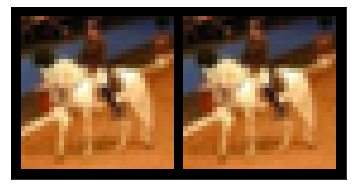

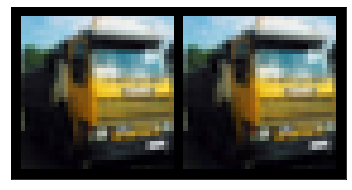

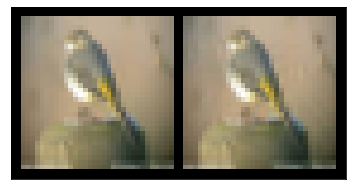

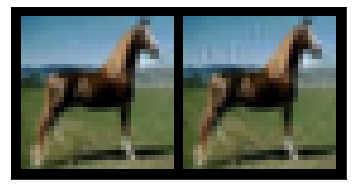

In [13]:
import torchvision as TV
inv_normalize = transforms.Normalize(
        mean=mean,
        std=std
      )


for i in range(0,adversarial_examples.size()[0]):
 
  inv1 =inputs[i] / 2 + 0.5
  TV.utils.save_image(inv1, join(paths.CIFAR10_CW_LOGS,'%d_original.png' %(i)))
  inv2 = adversarial_examples[i] / 2 + 0.5
  TV.utils.save_image(inv2, join(paths.CIFAR10_CW_LOGS,'%d_adversarial.png' %(i)))
  list_img = [inv1, inv2]
  grid = utils.make_grid(list_img)
  show(grid)


#MNIST

## Load Data

In [14]:
mean = [0.5]
std= [0.5]
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root = '/content/MNIST', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(28),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                           ])),batch_size=9, shuffle=True)

test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root = '/content/MNIST', train=False, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(28),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize(0.5, 0.5),
                           ])),batch_size=128, shuffle=True)

## Neural Network

In [15]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 10, kernel_size=3, stride=3)
        self.bn2 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(-1, 10 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = MnistCNN()

## Training

In [16]:
model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.212
[1,   400] loss: 0.144
[1,   600] loss: 0.083
[1,   800] loss: 0.051
[1,  1000] loss: 0.037
[1,  1200] loss: 0.033
[1,  1400] loss: 0.030
[1,  1600] loss: 0.028
[1,  1800] loss: 0.024
[1,  2000] loss: 0.022
[1,  2200] loss: 0.020
[1,  2400] loss: 0.021
[1,  2600] loss: 0.022
[1,  2800] loss: 0.018
[1,  3000] loss: 0.015
[1,  3200] loss: 0.018
[1,  3400] loss: 0.015
[1,  3600] loss: 0.017
[1,  3800] loss: 0.017
[1,  4000] loss: 0.014
[1,  4200] loss: 0.016
[1,  4400] loss: 0.017
[1,  4600] loss: 0.014
[1,  4800] loss: 0.013
[1,  5000] loss: 0.014
[1,  5200] loss: 0.015
[1,  5400] loss: 0.015
[1,  5600] loss: 0.015
[1,  5800] loss: 0.016
[1,  6000] loss: 0.014
[1,  6200] loss: 0.014
[1,  6400] loss: 0.014
[1,  6600] loss: 0.010
[2,   200] loss: 0.012
[2,   400] loss: 0.013
[2,   600] loss: 0.012
[2,   800] loss: 0.010
[2,  1000] loss: 0.013
[2,  1200] loss: 0.012
[2,  1400] loss: 0.010
[2,  1600] loss: 0.010
[2,  1800] loss: 0.009
[2,  2000] loss: 0.011
[2,  2200] 

In [17]:
PATH = '/content/drive/MyDrive/TFG/MNIST/MNIST_net.pth'
torch.save(model.state_dict(), paths.MNIST_DIR)

## Attack

In [18]:
model.load_state_dict(torch.load(paths.MNIST_DIR))

model.to(device)

inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))

# a targeted adversary
adversary = L2Adversary(targeted=True,
                           k=0.0,
                           search_steps=10,
                           box=inputs_box,
                           learning_rate=5e-4)


dataiter = iter(train_loader) #inputs images
inputs, _ = dataiter.next()

inputs.to(device)

target_class_idx = 3
attack_targets = torch.ones(inputs.size(0)) * target_class_idx #target one-hot encoded

NUM_CLASSES = 10
adversarial_examples = adversary.attack(model, inputs, attack_targets, NUM_CLASSES)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()


Using scale consts: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
batch 0 loss: 0.10489397495985031
batch 10 loss: 0.10488148778676987
batch 20 loss: 0.10487096756696701
batch 30 loss: 0.10486684739589691
batch 40 loss: 0.10486584901809692
batch 50 loss: 0.10486537218093872
batch 60 loss: 0.104865163564682
batch 70 loss: 0.10486504435539246
batch 80 loss: 0.10486497730016708
batch 90 loss: 0.1048649251461029
batch 100 loss: 0.10486489534378052
batch 110 loss: 0.10486488044261932
batch 120 loss: 0.10486486554145813
batch 130 loss: 0.10486487299203873
batch 140 loss: 0.10486487299203873
batch 150 loss: 0.10486486554145813
batch 160 loss: 0.10486485064029694
batch 170 loss: 0.10486485809087753
batch 180 loss: 0.10486486554145813
batch 190 loss: 0.10486485809087753
batch 200 loss: 0.10486486554145813
Using scale consts: [0.01, 0.0005, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
batch 0 loss: 1.048386573791504
batch 10 loss: 1.0468811988830566
batch 20 loss: 1.04656243324279

## Display results 

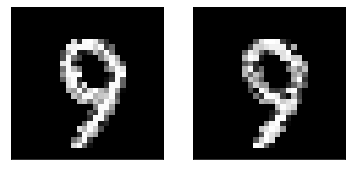

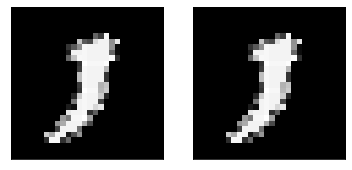

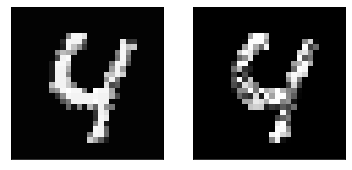

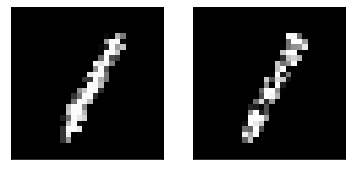

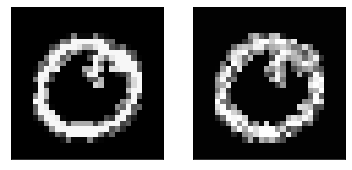

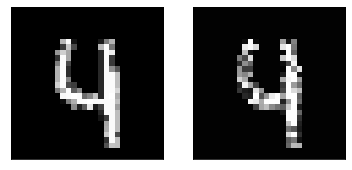

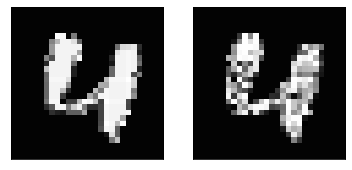

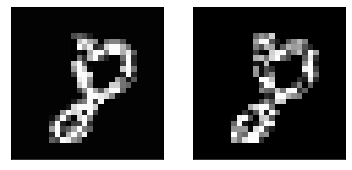

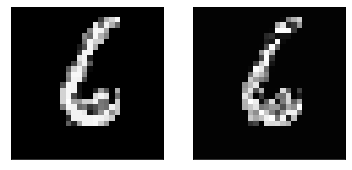

In [19]:
import torchvision as TV
inv_normalize = transforms.Normalize(
        mean=mean,
        std=std
      )

for i in range(0,adversarial_examples.size()[0]):

  
  inv1 = inv_normalize(inputs[i])
  TV.utils.save_image(inv1.reshape(28,28), join(paths.MNIST_CW_LOGS, "%d_original.png" %(i)),)

  inv2 =inv_normalize(adversarial_examples[i]) 
  TV.utils.save_image(adversarial_examples[i].reshape(28,28), join(paths.MNIST_CW_LOGS, "%d_adversarial.png" %(i)))

  list_ad = [inv1,inv2]
  show(list_ad,gray=True)
  